In [68]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import DataProcessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input, Dropout,Attention, Activation, Flatten, TimeDistributed, RepeatVector, Permute, Multiply, Lambda,Bidirectional
from keras import backend as K

dataProcess = DataProcessing.ETL()
df = dataProcess.Load_Clean_Data('./historical_data/Binance_ETHUSDT_d.csv','1d')

cols= ['ti_stoch_kd','ti_MACD']
cols_to_normalize = ['open','high', 'low', 'close', 'base_volume'] # removed num_trades
df = dataProcess.Add_TI_Data(df, cols=cols)
df= dataProcess.Add_Label(df,cols_to_normalize=cols_to_normalize)
#important: reverse the order and Reset the index to start from 0
df= df[::-1]
df.reset_index(drop=True, inplace=True)


#removed time ('unix_start_datetime')
x_cols = cols_to_normalize+cols
labels = ['result_A','result_B']
tensor_temp= df[x_cols+labels]
sequence_num=14 # also called timesteps
tensor = dataProcess.create_tensor_with_sequence(tensor_temp,labels,sequence_num)
#note we have 2 labels, one for daily(B) another for shortterm (A) => shorterm>daily
#y1= df['result_A']
X= tensor.loc[:,~tensor.columns.isin(labels)]


y2= tensor['result_B']
y = y2.replace({'up': 0, 'down': 1, 'flat':2})
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(f'integer_encoded is {integer_encoded}')
y = to_categorical(y, num_classes=3)
print(y)
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
# further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# print the shape of each set
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
print("Training data shape:", y_train.shape)
print("Validation data shape:", y_val.shape)
print("Test data shape:", y_test.shape)

created
integer_encoded is [2 1 0 ... 0 2 0]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
Training data shape: (1121, 105)
Validation data shape: (281, 105)
Test data shape: (602, 105)
Training data shape: (1121, 3)
Validation data shape: (281, 3)
Test data shape: (602, 3)


In [ ]:
integer_encoded[-100:-1]

array([0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 2, 2, 1, 1, 0, 0, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2,
       2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0,
       2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 2])

: 

: 

In [ ]:
# Important: reshape it into a 3D tensor with dimensions (number of samples, sequence length, number of features) to process with LSTM
X_train = X_train.to_numpy().reshape(X_train.shape[0],sequence_num+1,len(x_cols))
X_test = X_test.to_numpy().reshape(X_test.shape[0],sequence_num+1,len(x_cols))
X_val = X_val.to_numpy().reshape(X_val.shape[0],sequence_num+1,len(x_cols))

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

: 

: 

In [ ]:
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
model = Sequential([
Bidirectional(LSTM(units=84, return_sequences=True, input_shape=(sequence_num+1,len(x_cols)))),
Dropout(0.4),
Bidirectional(LSTM(units=64, return_sequences=True)),
Dropout(0.6),
Bidirectional(
    LSTM(
    units=32,
    return_sequences=True
    )),
# Dropout(0.7),
Dropout(0.7),
SeqSelfAttention(attention_activation='tanh'),
Flatten(),
Dense(3,activation='softmax')])


model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 30)


Epoch 1/30


/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


36/36 [==============================] - 8s 60ms/step - loss: 0.9736 - accuracy: 0.4996 - precision_9: 0.5080 - recall_9: 0.2275 - tp: 255.0000 - fp: 247.0000 - tn: 1995.0000 - fn: 866.0000 - val_loss: 0.9181 - val_accuracy: 0.5231 - val_precision_9: 0.5529 - val_recall_9: 0.4093 - val_tp: 115.0000 - val_fp: 93.0000 - val_tn: 469.0000 - val_fn: 166.0000
Epoch 2/30
36/36 [==============================] - 1s 28ms/step - loss: 0.9135 - accuracy: 0.5379 - precision_9: 0.5559 - recall_9: 0.3417 - tp: 383.0000 - fp: 306.0000 - tn: 1936.0000 - fn: 738.0000 - val_loss: 0.9435 - val_accuracy: 0.5231 - val_precision_9: 0.5228 - val_recall_9: 0.4484 - val_tp: 126.0000 - val_fp: 115.0000 - val_tn: 447.0000 - val_fn: 155.0000
Epoch 3/30
36/36 [==============================] - 1s 26ms/step - loss: 0.9043 - accuracy: 0.5442 - precision_9: 0.5618 - recall_9: 0.4095 - tp: 459.0000 - fp: 358.0000 - tn: 1884.0000 - fn: 662.0000 - val_loss: 0.9052 - val_accuracy: 0.5552 - val_precision_9: 0.5923 - val_r

: 

: 

In [ ]:
print(y_test)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


: 

: 

In [ ]:
temp = np.where(np.argmax(y_test)==1)
print(temp)

(array([0]),)


: 

: 

In [ ]:


# # Predict the test set labels
y_pred = model.predict(X_test)

19/19 [==============================] - 1s 7ms/step
Accuracy: 0.5764119625091553
Precision: 0.5829596519470215
Recall: 0.4318936765193939
F1 Score: 0.4961832025960536
True Positive: 260.0
True Negative: 1018.0
False Positive: 186.0
False Negative: 342.0


: 

: 

In [ ]:
print(y_val.shape)
y_pred = model.predict(X_val)
index_test = 2
a=0
b=1
temp1=[]
# for i in range(y_val.shape[0]):
#     if(y_val[i][index_test] > y_val[i][a] and y_val[i][index_test] > y_val[i][b]):
#         print(y_val[i])
#         print(f'corr {y_pred[i]}')

for i in range(y_pred.shape[0]):
    if(y_pred[i][index_test] > y_pred[i][1] and y_pred[i][index_test] > y_pred[i][0]):
        print('lol')
        print(y_pred[i])

(389, 3)
13/13 [==============================] - 0s 6ms/step


: 

: 

In [ ]:
# create an empty binary array with the same shape as probs_2d
binary_2d = np.zeros_like(y_pred)
# loop through each row of probs_2d
# loop through each row of probs_2d
for i in range(y_pred.shape[0]):
    # set values above 0.35 to 1, and below to 0
    temp = []
    isAdded = False
    for val in y_pred[i]:
        if val > 0.35:
            if not isAdded:
                temp.append(1)
                isAdded = True
            elif val >= max(temp):
                temp = [0 for _ in range(len(temp))]
                temp.append(1)
            else:
                temp.append(0)
        else:
            temp.append(0)
            isAdded = False
    binary_2d[i] = np.array(temp)
print(binary_2d)


[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


: 

: 

In [ ]:
from sklearn.metrics import classification_report
print(y_test.shape)
print(binary_2d.shape)
print(classification_report(y_test, binary_2d))


(602, 3)
(602, 3)
              precision    recall  f1-score   support

           0       0.49      0.86      0.62       264
           1       0.66      0.33      0.44       270
           2       0.00      0.00      0.00        68

   micro avg       0.52      0.52      0.52       602
   macro avg       0.38      0.40      0.35       602
weighted avg       0.51      0.52      0.47       602
 samples avg       0.52      0.52      0.52       602



/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 

: 

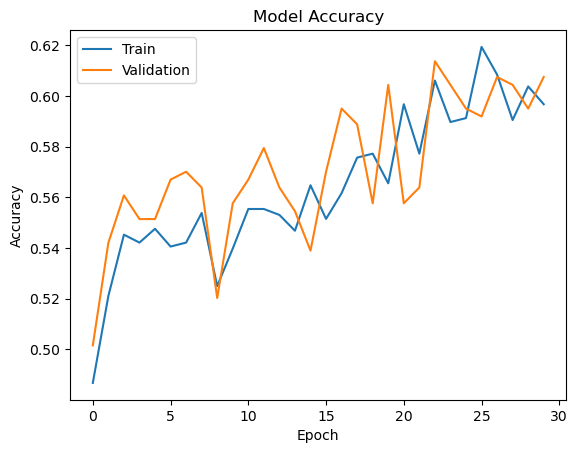

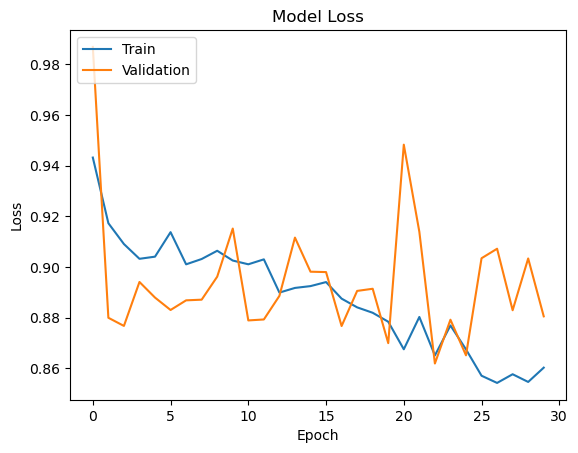

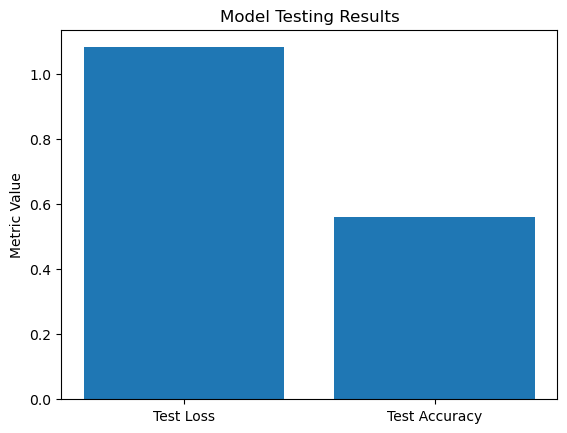

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate model on test data



In [ ]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_131 (Bidirect  (None, 15, 168)          61824     
 ional)                                                          
                                                                 
 dropout_121 (Dropout)       (None, 15, 168)           0         
                                                                 
 bidirectional_132 (Bidirect  (None, 15, 128)          119296    
 ional)                                                          
                                                                 
 dropout_122 (Dropout)       (None, 15, 128)           0         
                                                                 
 bidirectional_133 (Bidirect  (None, 15, 64)           41216     
 ional)                                                          
                                                     

: 

: 

: 

In [ ]:
#code to use softmax as the last layer for classifying up down flat along with the probability

import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# Create a simple neural network model
model = Sequential()
model.add(Dense(3, input_dim=4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Generate some input data
X = np.array([[1, 2, 3, 4]])

# Get the predicted probabilities for each class
y_pred = model.predict(X)

# Get the predicted class label and associated probability
predicted_class_label = np.argmax(y_pred)
predicted_probability = y_pred[0][predicted_class_label]

# Print the results
print('Predicted class label:', predicted_class_label)
print('Associated probability:', predicted_probability)

: 

: 

: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return K.mean(f1)

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1])






created


/Users/pratyushpradhan/Developer/Personal/Projects/Crypto/CryptoDataProcessingAndML/Version2/DataProcessing.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  MACD = ta.macd(df['close'])


[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Epoch 1/24
41/41 [==============================] - 7s 46ms/step - loss: 0.9674 - accuracy: 0.4899 - val_loss: 0.8788 - val_accuracy: 0.5607
Epoch 2/24
41/41 [==============================] - 1s 23ms/step - loss: 0.9418 - accuracy: 0.5062 - val_loss: 0.8922 - val_accuracy: 0.4984
Epoch 3/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9231 - accuracy: 0.5094 - val_loss: 0.9048 - val_accuracy: 0.5109
Epoch 4/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9237 - accuracy: 0.5265 - val_loss: 0.8931 - val_accuracy: 0.5483
Epoch 5/24
41/41 [==============================] - 1s 23ms/step - loss: 0.9246 - accuracy: 0.5164 - val_loss: 0.8862 - val_accuracy: 0.5607
Epoch 6/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9231 - accuracy: 0.5296 - val_loss: 0.8952 - val_accuracy: 0.5576
Epoch 7/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9

: 

: 

: 

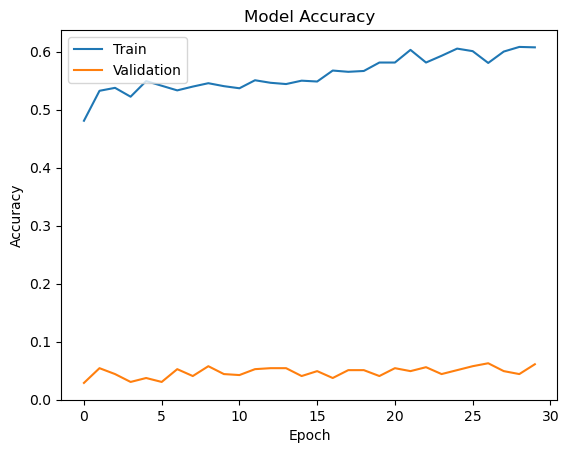

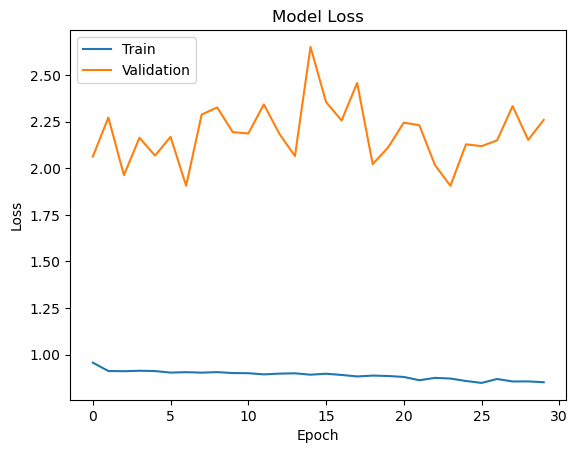

NameError: name 'loss' is not defined

: 

: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate model on test data

# Plot testing accuracy and loss
plt.bar(['Test Loss', 'Test Accuracy'], [loss, accuracy])
plt.title('Model Testing Results')
plt.ylabel('Metric Value')
plt.show()

In [ ]:
model.summary()

: 

: 

: 

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import DataProcessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input, Dropout,Attention, Activation, Flatten, TimeDistributed, RepeatVector, Permute, Multiply, Lambda,Bidirectional
from keras import backend as K
from imblearn.over_sampling import SMOTE

dataProcess = DataProcessing.ETL()
df = dataProcess.Load_Clean_Data('./historical_data/Binance_ETHUSDT_d.csv','1d')

cols= ['ti_stoch_kd','ti_MACD']
cols_to_normalize = ['open','high', 'low', 'close', 'base_volume'] # removed num_trades
df = dataProcess.Add_TI_Data(df, cols=cols)
df= dataProcess.Add_Label(df,cols_to_normalize=cols_to_normalize)
#important: reverse the order and Reset the index to start from 0
df= df[::-1]
df.reset_index(drop=True, inplace=True)


#removed time ('unix_start_datetime')
x_cols = cols_to_normalize+cols
labels = ['result_A','result_B']
tensor_temp= df[x_cols+labels]
sequence_num=14 # also called timesteps
tensor = dataProcess.create_tensor_with_sequence(tensor_temp,labels,sequence_num)
#note we have 2 labels, one for daily(B) another for shortterm (A) => shorterm>daily
#y1= df['result_A']
X= tensor.loc[:,~tensor.columns.isin(labels)]


y2= tensor['result_B']

y = y2.replace({'up': 0, 'down': 1, 'flat':2})
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(f'integer_encoded is {integer_encoded}')
y = to_categorical(y, num_classes=3)
count3 = np.count_nonzero((y == [0, 0, 1]).all(axis=1))
print(count3)
# # Create the oversampling object
# smote = SMOTE()
# # Oversample the data
# X_resampled, y_resampled = smote.fit_resample(X, y)
# count4 = np.count_nonzero((y_resampled == [0, 0, 1]).all(axis=1))


# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
# further split training data into training and validation sets
# Create the oversampling object
smote = SMOTE()
# Oversample the data
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

# Important: reshape it into a 3D tensor with dimensions (number of samples, sequence length, number of features) to process with LSTM
X_train = X_train.to_numpy().reshape(X_train.shape[0],sequence_num+1,len(x_cols))
X_test = X_test.to_numpy().reshape(X_test.shape[0],sequence_num+1,len(x_cols))
X_val = X_val.to_numpy().reshape(X_val.shape[0],sequence_num+1,len(x_cols))

from keras_self_attention import SeqSelfAttention
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
model = Sequential([
Bidirectional(LSTM(units=120, return_sequences=True, input_shape=(sequence_num+1,len(x_cols)))),
Dropout(0.4),
Bidirectional(LSTM(units=64,
                    return_sequences=True
                    )),
Dropout(0.6),
Bidirectional(
    LSTM(
    units=32,
    return_sequences=True
    )),
Dropout(0.7),
SeqSelfAttention(attention_activation='tanh'),
Flatten(),
Dense(3,activation='softmax')])


model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 30)


created
integer_encoded is [2 1 0 ... 0 2 0]
183
Epoch 1/30


/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 7s 43ms/step - loss: 0.9570 - accuracy: 0.4807 - precision_5: 0.5033 - recall_5: 0.2233 - tp: 307.0000 - fp: 303.0000 - tn: 2447.0000 - fn: 1068.0000 - val_loss: 2.0626 - val_accuracy: 0.0288 - val_precision_5: 0.0411 - val_recall_5: 0.0237 - val_tp: 14.0000 - val_fp: 327.0000 - val_tn: 853.0000 - val_fn: 576.0000
Epoch 2/30
43/43 [==============================] - 1s 23ms/step - loss: 0.9123 - accuracy: 0.5324 - precision_5: 0.5420 - recall_5: 0.3193 - tp: 439.0000 - fp: 371.0000 - tn: 2379.0000 - fn: 936.0000 - val_loss: 2.2719 - val_accuracy: 0.0542 - val_precision_5: 0.0627 - val_recall_5: 0.0373 - val_tp: 22.0000 - val_fp: 329.0000 - val_tn: 851.0000 - val_fn: 568.0000
Epoch 3/30
43/43 [==============================] - 1s 24ms/step - loss: 0.9110 - accuracy: 0.5375 - precision_5: 0.5573 - recall_5: 0.3607 - tp: 496.0000 - fp: 394.0000 - tn: 2356.0000 - fn: 879.0000 - val_loss: 1.9629 - val_accuracy: 0.0441 - val_precision_5: 0.0548 - val_r

: 

: 

In [ ]:
print(y_val.shape)
y_pred = model.predict(X_val)
index_test = 2
a=0
b=1
temp1=[]
# for i in range(y_val.shape[0]):
#     if(y_val[i][index_test] > y_val[i][a] and y_val[i][index_test] > y_val[i][b]):
#         print(y_val[i])
#         print(f'corr {y_pred[i]}')

for i in range(y_pred.shape[0]):
    if(y_pred[i][index_test] > y_pred[i][1] and y_pred[i][index_test] > y_pred[i][0]):
        print('lol')
        print(y_pred[i])
# create an empty binary array with the same shape as probs_2d
binary_2d = np.zeros_like(y_pred)
# loop through each row of probs_2d
# loop through each row of probs_2d
for i in range(y_pred.shape[0]):
    # set values above 0.35 to 1, and below to 0
    temp = []
    isAdded = False
    for val in y_pred[i]:
        if val > 0.35:
            if not isAdded:
                temp.append(1)
                isAdded = True
            elif val >= max(temp):
                temp = [0 for _ in range(len(temp))]
                temp.append(1)
            else:
                temp.append(0)
        else:
            temp.append(0)
            isAdded = False
    binary_2d[i] = np.array(temp)
print(binary_2d)

from sklearn.metrics import classification_report
print(y_val.shape)
print(binary_2d.shape)
print(classification_report(y_val, binary_2d))



(590, 3)
19/19 [==============================] - 1s 6ms/step
lol
[0.39660296 0.20058295 0.40281403]
lol
[0.36139953 0.12589219 0.51270825]
lol
[0.1342565  0.06491395 0.8008296 ]
lol
[0.19031404 0.10966475 0.70002127]
lol
[0.09185205 0.24635914 0.6617888 ]
lol
[0.1913916  0.07710449 0.7315039 ]
lol
[0.16005635 0.29510581 0.54483783]
lol
[0.12267429 0.2673848  0.60994095]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
(590, 3)
(590, 3)
              precision    recall  f1-score   support

           0       0.07      0.74      0.14        34
           1       0.03      0.57      0.06        14
           2       1.00      0.02      0.04       542

   micro avg       0.07      0.07      0.07       590
   macro avg       0.37      0.44      0.08       590
weighted avg       0.92      0.07      0.05       590
 samples avg       0.07      0.07      0.07       590



: 

: 

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)



print(classification_report(y_val, binary_2d))

: 

: 

In [ ]:
print(y_resampled.shape)
print(y.shape)

# print(y_resampled)

count=0
unique_arr = np.unique(y_resampled, axis=0)
print(f'unique = {unique_arr}')
count = np.count_nonzero((y_resampled == [0, 1, 0]).all(axis=1))
count2 = np.count_nonzero((y == [0, 1, 0]).all(axis=1))

print(count2)
# print(distinct_values)

# print(y_resampled)
# for val in y_resampled:
#     # print(val)
#     if (val == np.array([0,1,0])).all():
#         count+=1
# print(count)


(2775, 3)
(2004, 3)
unique = [[0 0 1]
 [0 1 0]
 [1 0 0]]
925


: 

: 